In [1]:
%load_ext autoreload
%autoreload 2

In [118]:
from dataval.dataset import WeatherDataset
from dataval.plot import violinplot
from dataval.train import Trainer

import matplotlib
import os
import pandas as pd
import seaborn as sns

In [123]:
ds = WeatherDataset(os.path.join(os.getcwd(), "canonical-partitioned-dataset"))

# Explore Data

We want to print statistics about the dataset that might help us create a model. Appendix C.2 has the description of features: https://arxiv.org/pdf/2107.07455.pdf

First, we look at the first partition.

In [93]:
!pip install scikit-learn --quiet

In [124]:
df = ds.load(ds.get_partition_keys()[0])
df.head()

,fact_time,fact_latitude,fact_longitude,fact_temperature,fact_cwsm_class,climate,topography_bathymetry,sun_elevation,climate_temperature,climate_pressure,...,cmc_0_1_66_0_next,cmc_0_1_67_0_grad,cmc_0_1_67_0_next,cmc_0_1_68_0_grad,cmc_0_1_68_0_next,gfs_2m_dewpoint_grad,gfs_2m_dewpoint_next,gfs_total_clouds_cover_low_grad,gfs_total_clouds_cover_low_next,year_month
0,2018-09-01,31.098301,61.543900,24.0,0.0,dry,482.0,-20.096423,27.061429,712.391668,...,0.00000,0.0,0.0,0.0,0.0,-0.669403,-1.519385,0.0,0.0,2018_09
1,2018-09-01,6.577370,3.321160,25.0,10.0,tropical,25.0,-76.180885,23.630714,755.882179,...,0.00000,0.0,0.0,0.0,0.0,0.030609,21.980615,6.0,7.0,2018_09
2,2018-09-01,43.080000,77.060000,6.0,0.0,mild temperate,3193.0,-4.649861,6.286429,518.198685,...,2.73922,0.0,0.0,0.0,0.0,9.100006,0.950006,0.0,0.0,2018_09
3,2018-09-01,-66.551944,93.014722,-17.0,20.0,tropical,-18.0,-5.075102,-13.020000,727.109700,...,0.02644,0.0,0.0,0.0,0.0,-1.199997,-37.650000,0.0,0.0,2018_09
4,2018-09-01,38.133900,46.235001,22.0,0.0,dry,1347.0,-27.818582,18.227857,631.498268,...,0.00000,0.0,0.0,0.0,0.0,-0.600006,2.350000,0.0,0.0,2018_09


<Axes: xlabel='fact_temperature', ylabel='fact_time'>

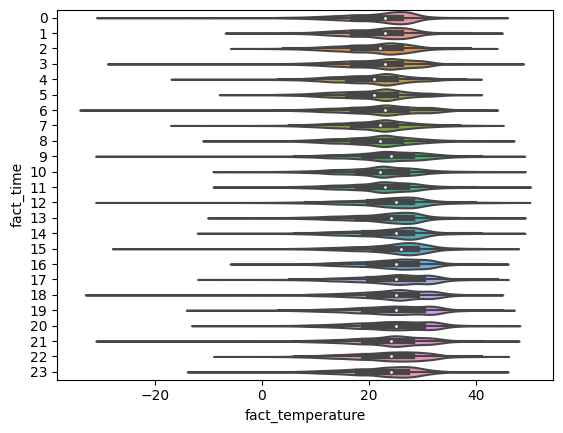

In [125]:
violinplot(df, "fact_temperature", "hour")

In [143]:
first_iter = True

for train_df, test_df in ds.iterate():
    X_train, y_train = ds.split_feature_label(train_df)
    
    if first_iter:
        catboost_hparams = {"depth": 8, "iterations": 2000, "learning_rate": 0.03}
        t = Trainer(catboost_hparams)
        print(f"Training for {ds.get_partition_key(train_df)}...")
        t.fit(X_train, y_train, verbose=100)
        first_iter = False
    
        print(f"\tTrain MSE: {t.score(X_train, y_train)}")
    
    # Evaluate
    X_test, y_test = ds.split_feature_label(test_df)
    print(f"\tMSE for {ds.get_partition_key(test_df)}: {t.score(X_test, y_test)}")

Training for 2018_09...
0:	learn: 6.8206415	test: 7.7127120	best: 7.7127120 (0)	total: 52.1ms	remaining: 1m 44s
100:	learn: 2.1399584	test: 2.2738103	best: 2.2738103 (100)	total: 4s	remaining: 1m 15s
200:	learn: 1.9808462	test: 2.1124569	best: 2.1124569 (200)	total: 7.96s	remaining: 1m 11s
300:	learn: 1.9199533	test: 2.0633735	best: 2.0633735 (300)	total: 12s	remaining: 1m 7s
400:	learn: 1.8767175	test: 2.0337403	best: 2.0337403 (400)	total: 16s	remaining: 1m 3s
500:	learn: 1.8423267	test: 2.0127147	best: 2.0127147 (500)	total: 20s	remaining: 59.7s
600:	learn: 1.8134090	test: 1.9947515	best: 1.9947515 (600)	total: 23.9s	remaining: 55.6s
700:	learn: 1.7886378	test: 1.9823754	best: 1.9823754 (700)	total: 27.7s	remaining: 51.3s
800:	learn: 1.7666381	test: 1.9722373	best: 1.9722373 (800)	total: 31.4s	remaining: 47s
900:	learn: 1.7469773	test: 1.9631982	best: 1.9631982 (900)	total: 35.2s	remaining: 43s
1000:	learn: 1.7283548	test: 1.9559612	best: 1.9559612 (1000)	total: 39.1s	remaining: 39s

In [150]:
# How many columns have a 0-valued feature importance

(t.getFeatureImportance() == 0).sum()

feature       0
importance    5
dtype: int64

In [152]:
t.get_feature_importance()

,feature,importance
6,cmc_0_0_0_2_interpolated,19.110930
89,gfs_temperature_sea_interpolated,14.050829
109,wrf_t2_interpolated,10.890928
99,wrf_t2,9.035060
0,topography_bathymetry,4.574235
...,...,...
108,wrf_hail,0.000000
25,cmc_0_1_68_0,0.000000
98,wrf_available,0.000000
54,gfs_available,0.000000
